In [17]:
!nvidia-smi

Fri Nov 29 15:59:26 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 425.31       Driver Version: 425.31       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GT 650M    WDDM  | 00000000:01:00.0 N/A |                  N/A |
| N/A   73C    P0    N/A /  N/A |     40MiB /  2048MiB |     N/A      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.nn.utils import parameters_to_vector, vector_to_parameters

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

from tqdm import tqdm

from termcolor import colored
import copy
import numpy as np
import pandas as pd
import os
import sys
from datetime import datetime


In [19]:
CLASSES_PATH = os.path.dirname(os.path.abspath("../../Classes"))
if not (CLASSES_PATH in sys.path):
    sys.path.append(CLASSES_PATH)
from Classes.Files_Handler_Class import Files_Handler
from Classes.Bcolors_Class import Bcolors as bcolors
from Classes.Average_Meter_Class import AverageMeter

In [20]:
layer_centrality = ['layer_density','layer_degree_histogram','layer_edge_weight',
                    'layer_sombor_index', 'layer_nodes_weight','layer_k_shell_weight']
node_centrality = ['degree', 'clustering', 'nip', 'sombor_index', 'ego_density','ego_degree',
                     'ego_k_shell', 'ego_degree_mean','kss', 'vote_power']
drop_centrality = ['layer_id', 'node_id', 'weight', 'k_shell', 'k_shell_itr']

In [47]:
best_train_model = False
loaded_model = '' # 'D:/Masters thesis/Networks Dataset/Results/Model/highest_epoch_train model lr=1e-07 wd=0 epochs=428  loss_valid=6.5379 loss_train=6.5929.pt'
loaded_node_layer_embedding_model = 'D:/Masters thesis/Code/Neural Network/Final_Models/Node_Layer_Embedding_Model/2024_11_29_15/model.pt' 
loaded_optimizer = '' # 'D:/Masters thesis/Networks Dataset/Results/Model/highest_epoch_train Adam lr=1e-07 wd=0 epochs=428  loss_valid=6.5379 loss_train=6.5929.optim'
data_path = 'D:/Masters thesis/Networks Dataset/Results/Monoplex/Clean Data/data.csv'


In [22]:
def get_content_of_csv_files(path: "str", files_list: "list", drop_culm:list[str]=[]):
    content_list = []
    for item in files_list:
        content_list.append(pd.read_csv(str(path + item)))
        content_list[-1] = content_list[-1].drop(drop_culm, axis=1)
        null_values = content_list[-1].isnull().sum()
        null_row_cunt = null_values.sum()
        if null_row_cunt > 0:
            print(item, null_row_cunt)
            for j, jtem in enumerate(null_values):
                if jtem > 0 :
                    print(list(content_list[-1])[j], jtem)
        content_list[-1] = content_list[-1].dropna()
    return content_list

In [23]:
select_file_object = Files_Handler()
multiple_selecion = False

# data_path = select_file_object.select_files("text files", ".csv", multiple_selecion)
path = ""
networks_content = []

if multiple_selecion:
    path = data_path[0][:data_path[0].rfind("/")] + "/"
    for item in data_path:
        networks_content.append(pd.read_csv(item))
else:
    path = data_path[:data_path.rfind("/")] + "/"
    networks_name = select_file_object.get_files_in_path(path,'csv')
    networks_content = get_content_of_csv_files(path, networks_name)
print(len(networks_name))

1


In [24]:
load_model_status = False
# loaded_model = select_file_object.select_files("Model file", ".pt", False)
loaded_lr, loaded_wd, loaded_epochs = None, None, None
if loaded_model != '':
    loaded_model_info = select_file_object.get_file_path_info(loaded_model)
    if best_train_model:
      loaded_lr = float(loaded_model_info['name'].split(" ")[2].split("=")[1])
      loaded_wd = float(loaded_model_info['name'].split(" ")[3].split("=")[1])
      loaded_epochs = int(loaded_model_info['name'].split(" ")[4].split("=")[1])
    else:
      loaded_lr = float(loaded_model_info['name'].split(" ")[2].split("=")[1])
      loaded_wd = float(loaded_model_info['name'].split(" ")[3].split("=")[1])
      loaded_epochs = int(loaded_model_info['name'].split(" ")[4].split("=")[1])

    load_model_status = True
if load_model_status:
  print(bcolors.OKGREEN + f"Load model: {load_model_status}" + bcolors.ENDC)
  print()
  print(bcolors.OKBLUE + loaded_model_info['path']+ bcolors.ENDC)
  print(bcolors.WARNING + loaded_model_info['name']+ bcolors.ENDC)
  print()
  print(bcolors.OKGREEN + f"loaded_lr: {loaded_lr}"  + bcolors.ENDC)
  print(f"loaded_wd: {loaded_wd}")
  print(bcolors.FAIL + f"loaded_epochs: {loaded_epochs}" + bcolors.ENDC)
else:
   print(bcolors.FAIL + f"Load model: {load_model_status}" + bcolors.ENDC)


Load model: False


In [25]:
data = pd.concat(networks_content, axis=0)
del networks_content

In [26]:
y_data = data['SIR'].values
data = data.drop(['SIR','class_type'], axis=1)

In [27]:
# import math
# from scipy import stats
# for column in list(data):
#     kde = stats.gaussian_kde(data[column])
#     x = np.linspace(data[column].min(), data[column].max(), 100)
#     y = kde(x)
#     plt.figure(figsize=(10,6))
#     plt.plot(x, y)
#     plt.fill_between(x, y, alpha=0.5)
#     plt.xlabel(column)
#     plt.ylabel('Frequency')
#     plt.xlim(math.floor(data[column].min()), math.ceil(data[column].max()))
#     plt.show()

In [28]:
# def feature_selection():
#     for column in list(data):
#         column_mean = data[column].mean()
#         # print(column)
#         # print(column_mean)
#         if column_mean >= (1/10000) and column_mean < (1/1000):
#             data[column] = data[column] * 1000
#         elif column_mean >= (1/1000) and column_mean < (1/100):
#             data[column] = data[column] * 100
#         elif column_mean >= (1/100) and column_mean < (1/10):
#             data[column] = data[column] * 10
#         elif column_mean >= 10 and column_mean < 100:
#             data[column] = data[column] / 10
#         elif column_mean >= 100 and column_mean < 1000:
#             data[column] = data[column] / 100
#         elif column_mean >= 1000 and column_mean < 10000:
#             data[column] = data[column] / 1000
#         elif column_mean >= 10000 and column_mean < 100000:
#             data[column] = data[column] / 10000
#         elif column_mean >= 100000 and column_mean < 1000000:
#             data[column] = data[column] / 100000
#         elif column_mean >= 1000000 and column_mean < 10000000:
#             data[column] = data[column] / 10000000
#         elif column_mean >= 10000000 and column_mean < 100000000:
#             data[column] = data[column] / 100000000
#         column_mean = data[column].mean()
#         # print(column_mean, '\n')

In [29]:
# import math
# from scipy import stats
# for column in list(data):
#     kde = stats.gaussian_kde(data[column])
#     x = np.linspace(data[column].min(), data[column].max(), 100)
#     y = kde(x)
#     plt.figure(figsize=(10,6))
#     plt.plot(x, y)
#     plt.fill_between(x, y, alpha=0.5)
#     plt.xlabel(column)
#     plt.ylabel('Frequency')
#     plt.xlim(math.floor(data[column].min()), math.ceil(data[column].max()))
#     plt.show()

In [30]:
data[node_centrality].head(3)

,degree,clustering,nip,sombor_index,ego_density,ego_degree,ego_k_shell,ego_degree_mean,kss,vote_power
0,1,0.000000,0.000931,0.000520,0.000253,-0.006550,0.000001,0.006845,0.00200,1.000000
1,12,0.409091,0.002001,0.002322,0.000704,-0.005338,0.000794,0.010925,0.04172,2.679797
2,16,0.350000,0.006281,0.006236,0.000988,-0.020915,0.001494,0.037572,0.06944,2.667096


In [31]:
data[layer_centrality].head(3)

,layer_density,layer_degree_histogram,layer_edge_weight,layer_sombor_index,layer_nodes_weight,layer_k_shell_weight
0,0.003593,25.352133,0.89455,7.879035,0.7057,33.705675
1,0.003593,25.352133,0.89455,7.879035,0.7057,33.705675
2,0.003593,25.352133,0.89455,7.879035,0.7057,33.705675


In [32]:
import scipy.stats as stats
alpha = 0.5

for i, item in enumerate(node_centrality):
    j =  i + 1
    while j < (len(node_centrality) -1):
        _,p_value = stats.ttest_ind(a=data[item].values, b=data[node_centrality[j]].values, equal_var=False)
        if p_value > alpha:
            print(bcolors.FAIL + item + " -> " + node_centrality[j]+ ": " + str(p_value) + bcolors.ENDC)
        j += 1

In [ ]:
# data = data.sample(frac = 1) # Shuffle data

# std_scaler = StandardScaler()
# data_scaled = std_scaler.fit_transform(data.to_numpy())
# data_scaled = pd.DataFrame(data_scaled, columns=[node_centrality + layer_centrality])

# data = data_scaled

# data_min = data.min()
# data_max = data.max()
# data_scaled = (data-data_min)/(data_max-data_min)

# data = data_scaled

In [33]:
layer_x_data = data[layer_centrality].values
node_x_data = data[node_centrality].values

print(bcolors.OKBLUE + f"Node Data: {node_x_data.shape}" + bcolors.ENDC)
print(bcolors.FAIL + f"Layer Data: {layer_x_data.shape}" + bcolors.ENDC)
print(bcolors.OKGREEN + f"SIR Data: {y_data.shape}" + bcolors.ENDC)

del data

Node Data: (64535, 10)
Layer Data: (64535, 6)
SIR Data: (64535,)


In [34]:
node_x_data = torch.FloatTensor(node_x_data)
layer_x_data = torch.FloatTensor(layer_x_data)
y_data = torch.FloatTensor(y_data)

print(bcolors.OKBLUE + f"Node Data: {node_x_data.shape}" + bcolors.ENDC)
print(bcolors.FAIL + f"Layer Data: {layer_x_data.shape}" + bcolors.ENDC)
print(bcolors.OKGREEN + f"Ground Truth: {y_data.shape}" + bcolors.ENDC)
# node_x_data

Node Data: torch.Size([64535, 10])
Layer Data: torch.Size([64535, 6])
Ground Truth: torch.Size([64535])


In [36]:
(node_x_train, node_x_test,
layer_x_train, layer_x_test,
y_train, y_test) = train_test_split(node_x_data, layer_x_data, y_data,
                                    train_size=0.8, shuffle=True, random_state=64)

if True:
    print(bcolors.OKBLUE + "Node Data:")
    print("  Train: " + str(node_x_train.shape))
    print("  Test:  "  + str(node_x_test.shape) + bcolors.ENDC)
    print()
    print(bcolors.FAIL + "Layer Data:")
    print("  Train: " + str(layer_x_train.shape))
    print("  Test:  " + str(layer_x_test.shape) + bcolors.ENDC)
    print()
    print(bcolors.OKGREEN + "Ground Truth:")
    print("  Train: " + str(y_train.shape))
    print("  Test:  " + str(y_test.shape) + bcolors.ENDC)

Node Data:
  Train: torch.Size([51628, 10])
  Test:  torch.Size([12907, 10])

Layer Data:
  Train: torch.Size([51628, 6])
  Test:  torch.Size([12907, 6])

Ground Truth:
  Train: torch.Size([51628])
  Test:  torch.Size([12907])


In [37]:
#-------------------------------------------------------------
node_mu = node_x_train.mean(dim=0)
node_std = node_x_train.std(dim=0)
print(bcolors.OKGREEN + "node_mu:\n    " + bcolors.ENDC + str(node_mu) + '\n')
print(bcolors.OKGREEN + "node_std:\n    " + bcolors.ENDC  + str(node_std) + '\n\n')

node_x_train = (node_x_train - node_mu) / node_std
node_x_test = (node_x_test - node_mu) / node_std
#-------------------------------------------------------------
layer_mu = layer_x_train.mean(dim=0)
layer_std = layer_x_train.std(dim=0)
print(bcolors.FAIL + "layer_mu:\n   " + bcolors.ENDC + str(layer_mu) + '\n')
print(bcolors.FAIL + "layer_std:\n   " + bcolors.ENDC + str(layer_std) )

layer_x_train = (layer_x_train - layer_mu) / layer_std
layer_x_test = (layer_x_test - layer_mu) / layer_std
#-------------------------------------------------------------

node_mu:
    tensor([ 3.1680e+01,  2.0773e-01,  9.3232e-02,  7.6925e-02,  2.1246e-03,
        -1.1202e-01,  3.7942e-01,  6.6942e-01,  1.5046e+00,  2.6891e+00])

node_std:
    tensor([5.1193e+01, 2.5793e-01, 1.3750e-01, 1.3687e-01, 5.0966e-03, 6.4119e-01,
        1.5052e+00, 1.1517e+00, 4.8193e+00, 4.8490e+00])


layer_mu:
   tensor([7.3550e-03, 3.6733e+01, 1.2792e+00, 1.0452e+02, 6.8180e-01, 1.2566e+02])

layer_std:
   tensor([1.0870e-02, 3.9736e+01, 1.7023e+00, 2.1064e+02, 2.5813e-01, 1.7113e+02])


In [38]:
del node_x_data, layer_x_data, y_data

In [39]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
    torch.cuda.empty_cache()
device

'cpu'

In [40]:
train_set = TensorDataset(node_x_train, layer_x_train, y_train)
test_set = TensorDataset(node_x_test, layer_x_test, y_test)

In [41]:
del node_x_train, layer_x_train, y_train, node_x_test, layer_x_test, y_test

In [42]:
batch_size = 16
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [43]:
node_x, layer_x, y = next(iter(train_loader))
print(bcolors.OKBLUE + "Node data shape   . . . . : " + str(node_x.shape) + bcolors.ENDC)
print(bcolors.FAIL + "Layer data shape  . . . . : " + str(layer_x.shape) + bcolors.ENDC)
print(bcolors.OKGREEN + "Ground Truth data shape . : " + str(y.shape) + bcolors.ENDC)

Node data shape   . . . . : torch.Size([16, 10])
Layer data shape  . . . . : torch.Size([16, 6])
Ground Truth data shape . : torch.Size([16])


In [44]:
class Node_Embedding_Model(nn.Module):

    def __init__(
        self, node_in_features: int, node_out_features: int,
        bias: bool, activation: nn.modules.activation, device: str = "cpu",
        h0:int = 8, h1: int = 16, h2: int = 32, h3: int = 64, h4: int = 128, h5 = 256
    ):
        super().__init__()
        self.node_embeding = nn.Sequential(
            nn.Linear(in_features=node_in_features, out_features=h1, bias=bias, device=device),
            activation,
            nn.Linear(in_features=h1, out_features=h2, bias=bias, device=device),
            activation,
            nn.Linear(in_features=h2, out_features=h3, bias=bias, device=device),
            activation,
            nn.Linear(in_features=h3, out_features=h4, bias=bias, device=device),
            activation,
            nn.Linear(in_features=h4, out_features=node_out_features, bias=bias, device=device)
        )
        self.regression = nn.Sequential(
            nn.Linear(in_features=node_out_features, out_features=1, bias=False, device=device),
        )

    def forward(self, node_x):
        node_y = self.node_embeding(node_x).unsqueeze(dim=1)
        y = self.regression(node_y)
        return y
   
class Node_Layer_Embedding_Model(nn.Module):

    def __init__(
        self, node_in_features: int, node_out_features: int,
        layer_in_features: int, layer_out_features: int,        
        bias: bool, activation: nn.modules.activation, device: str = "cpu",
        h0:int = 8, h1: int = 16, h2: int = 32, h3: int = 64, h4: int = 128, h5 = 256
    ):
        super().__init__()
        self.node_embeding = nn.Sequential(
            nn.Linear(in_features=node_in_features, out_features=h1, bias=bias, device=device),
            activation,
            nn.Linear(in_features=h1, out_features=h2, bias=bias, device=device),
            activation,
            nn.Linear(in_features=h2, out_features=h3, bias=bias, device=device),
            activation,
            nn.Linear(in_features=h3, out_features=h4, bias=bias, device=device),
            activation,
            nn.Linear(in_features=h4, out_features=node_out_features, bias=bias, device=device)
        )
        self.layer_embeding = nn.Sequential(
            nn.Linear(in_features=layer_in_features, out_features=h1, bias=bias, device=device),
            activation,
            nn.Linear(in_features=h1, out_features=h2, bias=bias, device=device),
            activation,
            nn.Linear(in_features=h2, out_features=h3, bias=bias, device=device),
            activation,
            nn.Linear(in_features=h3, out_features=h4, bias=bias, device=device),
            activation,
            nn.Linear(in_features=h4, out_features=layer_out_features, bias=bias, device=device)
            )
        
        self.regression = nn.Sequential(
            nn.Linear(in_features=node_out_features, out_features=1, bias=False, device=device),
        )

    def forward(self, node_x, layer_x):
        node_y = self.node_embeding(node_x).unsqueeze(dim=2)
        layer_y = self.layer_embeding(layer_x).unsqueeze(dim=1)
        y = torch.matmul(node_y, layer_y)
        y = torch.mean(y, dim=1)
        y = self.regression(y)
        return y

class Multilayer_Full_Model(nn.Module):

    def __init__(
        self, node_in_features: int, node_out_features: int,
        layer_in_features: int, layer_out_features: int,
        encoder_head: int, num_encoder:int, encoder_activation: str,
        bias: bool, dropout: float,
        activation: nn.modules.activation, device: str = "cpu",
        h0:int = 8, h1: int = 16, h2: int = 32, h3: int = 64, h4: int = 128, h5 = 256
    ):
        super().__init__()
        self.node_embeding = nn.Sequential(
            nn.Linear(in_features=node_in_features, out_features=h1, bias=bias, device=device),
            activation,
            nn.Linear(in_features=h1, out_features=h2, bias=bias, device=device),
            activation,
            nn.Linear(in_features=h2, out_features=h3, bias=bias, device=device),
            activation,
            nn.Linear(in_features=h3, out_features=h4, bias=bias, device=device),
            activation,
            nn.Linear(in_features=h4, out_features=node_out_features, bias=bias, device=device)
        )
        self.layer_embeding = nn.Sequential(
            nn.Linear(in_features=layer_in_features, out_features=h1, bias=bias, device=device),
            activation,
            nn.Linear(in_features=h1, out_features=h2, bias=bias, device=device),
            activation,
            nn.Linear(in_features=h2, out_features=h3, bias=bias, device=device),
            activation,
            nn.Linear(in_features=h3, out_features=h4, bias=bias, device=device),
            activation,
            nn.Linear(in_features=h4, out_features=layer_out_features, bias=bias, device=device)
            )
        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=node_out_features, nhead=encoder_head,
                dim_feedforward=(4 * node_out_features), dropout=dropout,
                activation=encoder_activation, bias=bias,
                batch_first=True, device=device),
            num_encoder)
        self.regression = nn.Sequential(
            nn.Linear(in_features=node_out_features, out_features=h4, bias=bias, device=device),
            activation,
            nn.Linear(in_features=h4, out_features=h3, bias=bias, device=device),
            activation,
            nn.Linear(in_features=h3, out_features=h2, bias=bias, device=device),
            activation,
            nn.Linear(in_features=h2, out_features=h1, bias=bias, device=device),
            activation,
            nn.Linear(in_features=h1, out_features=h0, bias=bias, device=device),
            activation,
            nn.Linear(in_features=h0, out_features=1, bias=bias, device=device),

        )

    def forward(self, node_x, layer_x):
        node_y = self.node_embeding(node_x).unsqueeze(dim=2)
        layer_y = self.layer_embeding(layer_x).unsqueeze(dim=1)
        y = torch.matmul(node_y, layer_y)
        y = self.encoder(y)
        y = torch.mean(y, dim=1)
        y = self.regression(y)
        return y

In [45]:
model = None

def create_model ():
    node_in_features, node_out_features = 10, 256
    layer_in_features, layer_out_features = 6, 256
    encoder_head, num_encoder = 32, 2
    bias, dropout = True, 0.05
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    return Multilayer_Full_Model(
                    node_in_features=node_in_features, node_out_features=node_out_features,
                    layer_in_features=layer_in_features, layer_out_features=layer_out_features,
                    encoder_head=encoder_head, num_encoder=num_encoder, encoder_activation='gelu',
                    bias=bias, dropout=dropout,
                    activation=nn.GELU(), device=device).to(device)
    
if load_model_status:
    model = torch.load(loaded_model, map_location=torch.device(device))    
    print(bcolors.OKGREEN + 'Model load' + bcolors.ENDC)
else:
    model = create_model()
    print(bcolors.FAIL + 'Model create' + bcolors.ENDC)

model_location = next(model.parameters()).is_cuda
if model_location:
    print(bcolors.OKGREEN + "Model on GPU." + bcolors.ENDC)
else:
    print(bcolors.FAIL + "Model on CPU." + bcolors.ENDC)

def num_params(model):
  nums = sum(p.numel() for p in model.parameters()) / 1000
  return nums
print("Number of Model parameters: ", num_params(model))

Model create
Model on CPU.
Number of Model parameters:  1711.713


In [51]:
if not load_model_status:
    try:
        node_layer_embedding_model = torch.load(loaded_node_layer_embedding_model, map_location=torch.device(device))
        print(bcolors.OKGREEN + 'Node Layer Embedding Model load' + bcolors.ENDC)
    except:
        node_layer_embedding_model_path = select_file_object.select_files("text files", ".pt", False)
        node_layer_embedding_model = torch.load(node_layer_embedding_model_path, map_location=torch.device(device))
    
    pretrained_node_state_dict = node_layer_embedding_model.node_embeding.state_dict()
    pretrained_layer_state_dict = node_layer_embedding_model.layer_embeding.state_dict()
    model.node_embeding.load_state_dict(pretrained_node_state_dict)
    model.layer_embeding.load_state_dict(pretrained_layer_state_dict)
    for param in model.node_embeding.parameters():
        param.requires_grad = False
    for param in model.layer_embeding.parameters():
        param.requires_grad = False


Node Layer Embedding Model load


In [52]:
node_x_batch, layer_x_batch, y_batch = next(iter(train_loader))
outputs = model(node_x_batch.to(device), layer_x_batch.to(device)).squeeze(dim=1)
print('output shape: ', outputs.shape)
print('y shape:      ', y_batch.shape)

output shape:  torch.Size([16])
y shape:       torch.Size([16])


In [53]:
loss_fn = nn.HuberLoss()
loss = loss_fn(outputs.to(device), y_batch.to(device))
print(loss)

tensor(9.5413, grad_fn=<HuberLossBackward0>)


In [54]:
def train_one_epoch(model, train_loader:DataLoader,
                    loss_fn:nn.modules.activation, optimizer:torch.optim,
                    epoch:int=None, device:str='cuda'):
  model.train()
  loss_train = AverageMeter()
  with tqdm(train_loader, unit=" batch") as tepoch:
    for node_inputs, layer_inputs, targets in tepoch:
      if epoch is not None:
        tepoch.set_description(f"Train Epoch {epoch + 1}")
      node_inputs = node_inputs.to(device)
      layer_inputs = layer_inputs.to(device)
      # targets = targets.to(device)

      outputs = model(node_inputs, layer_inputs).squeeze(dim=1)
      loss = loss_fn(outputs.to(device), targets.to(device))
      # print(loss)

      loss.backward()
      nn.utils.clip_grad_norm_(model.parameters(), 0.5)

      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item())
      tepoch.set_postfix(loss=loss_train.avg)
  return model, loss_train.avg

In [55]:
def validation(model, test_loader:DataLoader,
               loss_fn:nn.modules.activation, epoch:int=None, device:str='cuda'):
  model.eval()
  with tqdm(test_loader, unit=" batch") as tepoch:
    with torch.no_grad():
      loss_valid = AverageMeter()
      # acc_valid = Accuracy().to(device)
      for node_inputs, layer_inputs, targets in tepoch:
        if epoch is not None:
          tepoch.set_description(f"Test  Epoch {epoch + 1}")
        node_inputs = node_inputs.to(device)
        layer_inputs = layer_inputs.to(device)
        # targets = targets.to(device)

        outputs = model(node_inputs, layer_inputs).squeeze(dim=1)
        loss = loss_fn(outputs.to(device), targets.to(device))

        loss_valid.update(loss.item())
        tepoch.set_postfix(loss=loss_valid.avg)
        # acc_valid(outputs, targets.int())
  return loss_valid.avg

In [56]:
best_lr = 0.001
best_wd = 0.
delta = -1
if loaded_optimizer == '':
  num_epochs = 3
  for lr in [0.01, 0.009, 0.007, 0.005, 0.003, 0.001, 0.0009, 0.0007, 0.0005, 0.0003, 0.0001]:
    for wd in [1e-4, 1e-5, 0.]:
      model = create_model().to(device)
      optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
      print(f'LR={lr}, WD={wd}')
      start_loss = torch.inf
      end_loss = torch.inf
      for epoch in range(num_epochs):
        model, loss, _ = train_one_epoch(model, train_loader, loss_fn, optimizer, epoch, device)
        if epoch == 0:
          start_loss = loss
        else:
          end_loss = loss
        if (start_loss - end_loss) > delta:
          delta = start_loss - end_loss
          best_lr = lr
          best_wd = wd
      print()

LR=0.01, WD=0.0001


Train Epoch 1:   0%|          | 5/3227 [00:35<6:26:00,  7.19s/ batch, loss=10.8]


KeyboardInterrupt: 

In [ ]:
lr = best_lr
wd = best_wd
if loaded_optimizer != '':
    optimizer = torch.load(loaded_optimizer, map_location=torch.device(device))
    print(bcolors.OKGREEN + 'Optimizer load' + bcolors.ENDC)
else:
    optimizer = optim.Adam(params=model.parameters(), lr=lr, weight_decay=wd)
    print(bcolors.FAIL + 'Optimizer create' + bcolors.ENDC)

lr = optimizer.param_groups[0]['lr']
wd = optimizer.param_groups[0]['weight_decay']
print("lr = " + str(lr), "\nwd = " + str(wd))

In [ ]:
loss_train_hist = []
loss_valid_hist = []
epoch_counter = 0
best_loss_train = torch.inf
best_loss_valid = torch.inf
if load_model_status:
    loss_train_hist = np.loadtxt(loaded_model_info['path'] + 'highest_epoch_loss_train_hist.txt').tolist()
    best_loss_train = min(loss_train_hist[315:])
    loss_valid_hist = np.loadtxt(loaded_model_info['path'] + 'highest_epoch_loss_valid_hist.txt').tolist()
    best_loss_valid = min(loss_valid_hist[315:])
    epoch_counter += len(loss_valid_hist)

print(len(loss_train_hist), len(loss_valid_hist))
print(best_loss_train, best_loss_valid)

0 0
inf inf


In [ ]:
current_date = datetime.now()
model_date = (str(current_date.year) + "_" + str(current_date.month) + "_" +
               str(current_date.day) + "_" + str(current_date.hour) + "_" +
               str(current_date.minute))
if load_model_status:
    source_code_path = loaded_model_info['path'][:-1][:loaded_model_info['path'][:].rfind("/")]
else:
    source_code_path = select_file_object.make_dir(str(os.getcwd()), '/Multilayer_Full_Model_Local')
source_code_path = source_code_path.replace("\\", "/")
print(source_code_path)


c:/Users/User1/Desktop/Ali/Codes/Multilayer_Full_Model_Local/


In [ ]:
num_epochs = 100

loaded_epoch_counter = len(loss_valid_hist)
model_info =  ("model lr=" + str(lr) + " wd=" + str(wd))
optimizer_info =  ("Adam lr=" + str(lr) + " wd=" + str(wd))
source_code_path = select_file_object.make_dir(source_code_path, str('/' + str(model_date)) + ' ' + model_info)
source_code_path = source_code_path.replace("\\", "/")

saved_mode = None
saved_mode_train = None

In [ ]:
loss_fn = nn.HuberLoss()

for epoch in range(num_epochs):
  # Train
  model, loss_train = train_one_epoch(model, train_loader,
                                       loss_fn, optimizer, epoch, device)
  # Validation
  loss_valid = validation(model, test_loader, loss_fn, epoch, device)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)
  epochs_info = " epochs=" + str(epoch + 1 + loaded_epoch_counter) + " "

  if loss_train < best_loss_train:
    if not(saved_mode_train is None):
      os.remove(saved_mode_train)
    saved_mode_train = (str(source_code_path + "best_loss_train " + model_info + epochs_info +
                     ' loss_valid=' + str(f'{loss_valid:.5}') +
                     ' loss_train=' + str(f'{loss_train:.5}') +".pt"))
    torch.save(model, saved_mode_train)
    saved_opimizer_train = (str(source_code_path + "best_loss_train " + optimizer_info + epochs_info +
                     ' loss_valid=' + str(f'{loss_valid:.5}') +
                     ' loss_train=' + str(f'{loss_train:.5}') +".optim"))
    torch.save(optimizer, saved_opimizer_train)
    np.savetxt((source_code_path + 'loss_train_hist.txt'), loss_train_hist)
    np.savetxt((source_code_path + 'loss_valid_hist.txt'), loss_valid_hist)
    best_loss_train = loss_train
    print(bcolors.OKGREEN + f'Train: Loss = {loss_train:.5}' + bcolors.ENDC)
  else:
    print(bcolors.FAIL + f'Train: Loss = {loss_train:.5}' + bcolors.ENDC)

  if loss_valid < best_loss_valid:
    if not(saved_mode is None):
      os.remove(saved_mode)
    saved_mode = (str(source_code_path + 'best_loss_valid ' + model_info + epochs_info +
                     ' loss_valid=' + str(f'{loss_valid:.5}') +
                     ' loss_train=' + str(f'{loss_train:.5}') +".pt"))
    torch.save(model, saved_mode)
    saved_opimizer_train = (str(source_code_path + "best_loss_valid " + optimizer_info + epochs_info +
                     ' loss_valid=' + str(f'{loss_valid:.5}') +
                     ' loss_train=' + str(f'{loss_train:.5}') +".optim"))
    torch.save(optimizer, saved_opimizer_train)
    np.savetxt((source_code_path + 'loss_train_hist.txt'), loss_train_hist)
    np.savetxt((source_code_path + 'loss_valid_hist.txt'), loss_valid_hist)
    best_loss_valid = loss_valid
    print(bcolors.OKGREEN + f'Valid: Loss = {loss_valid:.5}' + bcolors.ENDC)
  else:
    print(bcolors.FAIL + f'Valid: Loss = {loss_valid:.5}' + bcolors.ENDC)

  print()
  saved_mode_train = (str(source_code_path + "highest_epoch_train " + model_info + epochs_info +
                     ' loss_valid=' + str(f'{loss_valid:.5}') +
                     ' loss_train=' + str(f'{loss_train:.5}') +".pt"))
  torch.save(model, saved_mode_train)
  saved_opimizer_train = (str(source_code_path + "highest_epoch_train " + optimizer_info + epochs_info +
                     ' loss_valid=' + str(f'{loss_valid:.5}') +
                     ' loss_train=' + str(f'{loss_train:.5}') + ".optim"))
  torch.save(optimizer, saved_opimizer_train)
  np.savetxt((source_code_path + 'highest_epoch_loss_train_hist.txt'), loss_train_hist)
  np.savetxt((source_code_path + 'highest_epoch_loss_valid_hist.txt'), loss_valid_hist)
  epoch_counter += 1


Test  Epoch 1: 100%|██████████| 2872/2872 [02:59<00:00, 16.02 batch/s, loss=87.5]


Train: Loss = 89.883
Valid: Loss = 87.462



Test  Epoch 2: 100%|██████████| 2872/2872 [04:01<00:00, 11.89 batch/s, loss=87.5]


Train: Loss = 89.881
Valid: Loss = 87.462



Train Epoch 3:  84%|████████▍ | 9673/11488 [58:12<09:06,  3.32 batch/s, loss=90]    

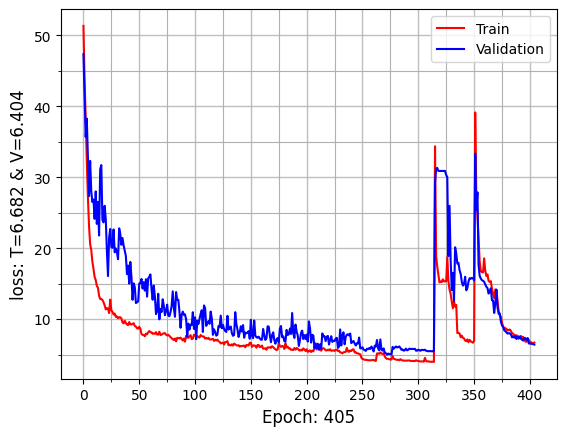

In [ ]:
from matplotlib.ticker import MultipleLocator
plt.plot(range(epoch_counter), loss_train_hist, "r-", label="Train")
plt.plot(range(epoch_counter), loss_valid_hist, "b-", label="Validation")

plt.xlabel("Epoch: " + str(epoch_counter))
plt.ylabel("loss: "
           + "T=" + str(f"{loss_train_hist[-1]:.4}")
           + " & "
           + "V=" + str(f"{loss_valid_hist[-1]:.4}")
)
x_spacing = 25
y_spacing = 5
x_minorLocator = MultipleLocator(x_spacing)
y_minorLocator = MultipleLocator(y_spacing)
plt.grid(visible=True, alpha=0.8, linewidth=1)
plt.legend()
ax = plt.gca()
ax.yaxis.label.set_fontsize('large')
ax.xaxis.label.set_fontsize('large')
ax.yaxis.set_minor_locator(y_minorLocator)
ax.xaxis.set_minor_locator(x_minorLocator)
ax.grid(which = 'minor')
plt.savefig(
    path
    + "epoch=" + str(len(loss_valid_hist))
    + " loss_valid=" + str(f"{loss_valid_hist[-1]:.5}")
    + " loss_train=" + str(f"{loss_train_hist[-1]:.5}")
    + ".png"
)

In [ ]:
# a = torch.FloatTensor([[1., 2., 3., 4.],
#                       [5., 6., 7., 8.],
#                       [9., 10., 11., 12.]])
# b = torch.FloatTensor([[1, 2, 3, 4],
#                       [5, 6, 7, 8],
#                       [9, 10, 11, 12]])
# print(a.shape)
# print(torch.mean(a, dim=1))
# print(torch.mean(a, dim=1).shape)
# print()
# print(b.shape)


In [ ]:
# a = torch.FloatTensor([[1., 2., 3., 4.],
#                       [5., 6., 7., 8.],
#                       [9., 10., 11., 12.]]).unsqueeze(dim=2)
# b = torch.FloatTensor([[1, 2, 3, 4],
#                       [5, 6, 7, 8],
#                       [9, 10, 11, 12]]).unsqueeze(dim=1)
# print(a.shape)
# print(b.shape)
# ab = torch.matmul(a, b)
# print()
# print (ab)
# print()
# print(ab.shape)

In [ ]:
# a = torch.FloatTensor([1,2,3,4]).unsqueeze(dim=1)
# b = torch.FloatTensor([1,2,3,4]).unsqueeze(dim=0)
# print(a)
# print(b)
# ab = torch.matmul(a, b)
# print()
# print (ab)
# print()
# print(ab.shape)